In [1]:
import random
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.optim import Adam
from torch.nn import functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline

from importlib import reload
import game2
import dqn_agent
game2 = reload(game2)
dqn_agent = reload(dqn_agent)
from game2 import Game
from dqn_agent import DQNAgent

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
# device = torch.device('cpu') 


In [3]:
moving_average = lambda x, **kw: pd.DataFrame({'x':np.asarray(x)}).x.ewm(**kw).mean().values

In [4]:
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.reshape(batch_size, -1)
    

In [5]:
class Policy(nn.Module):
    def __init__(self, in_channels, hid_channels, out_size, h=400, w=500):
      super(Policy, self).__init__()
      self.h = h
      self.w = w
      def conv2d_size_out(size, kernel_size = 4, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
      convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(conv2d_size_out(w))))
      convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(conv2d_size_out(h))))
      linear_input = convh * convw * hid_channels
      self.act = nn.Sequential(nn.Conv2d(in_channels, hid_channels, kernel_size=4, stride=2),
                               nn.BatchNorm2d(hid_channels),
                               nn.MaxPool2d(kernel_size=4,stride=2),
                               nn.ReLU(),
                               nn.Conv2d(hid_channels, hid_channels, kernel_size=4, stride=2),
                               nn.BatchNorm2d(hid_channels),
                               nn.MaxPool2d(kernel_size=4,stride=2),
                               nn.ReLU(),
                               Flattener(),
                               nn.Linear(linear_input, 500),
                               nn.ReLU(),
                               nn.Linear(500, out_size)
                               )
        
    def forward(self, X):
        if len(X.shape) < 4:
            X = X.view(1, X.shape[0], X.shape[1], X.shape[2])
        return self.act(X)
    
    def get_parameters(self):
       return self.state_dict()
    
    def set_parameters(self, state_dict):
        self.load_state_dict(state_dict)


In [6]:
torch.cuda.empty_cache()
in_channels = 3
hid_channels = 64
out_size = 3
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.ToPILImage(),
                                transforms.Resize(size=(100, 125)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.43,0.44,0.47], std=[0.20,0.20,0.20])]
                               )

model = Policy(in_channels, hid_channels, out_size, h=100, w=125).to(device)

In [7]:
batch_size = 32
optimizer = torch.optim.SGD(model.parameters(), lr=2.5e-4, momentum=0.95)
loss_func = nn.SmoothL1Loss()

dqn = DQNAgent(model, optimizer, loss_func , out_size, 5000, transform=transform, gamma=.99, epsilon=0.1)

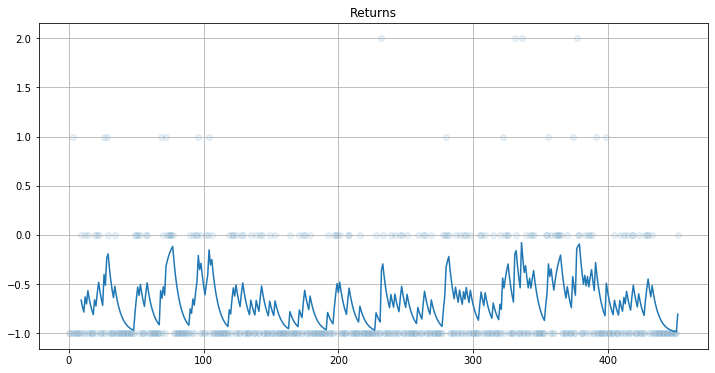

In [ ]:
env = Game(False)
dqn.fit(env, 1000, batch_size, train_every=100, update_model=200,  file_path=False)

In [ ]:
def test_agent(env, transform=None, agent=None, n_episodes=100):
    """Runs agent for n_episodes in environment and calclates mean reward.
    
    Args:
        env: The environment for agent to play in
        agent: The agent to play with. Defaults to None - 
            in this case random agent is used.
        n_episodes: Number of episodes to play. Defaults to 100.

    Returns:
        Mean reward for 100 episodes.
    """
    total_reward = []
    for episode in range(n_episodes):
        episode_reward = 0
        observation = env.reset()
        t = 0
        while True:
            if agent:
                agent.train(False)
                with torch.no_grad():
                    if transform:
                        observation = transform(observation)
                    probs = agent(torch.FloatTensor(observation).to(device))
                    action = torch.argmax(F.softmax(probs, dim=-1)).item()
            else:
                action = random.randint(0, 2)
            observation, reward, done, _  = env.step(action)
            episode_reward += reward
            t += 1
            if done:
                print("Episode {} finished after {} timesteps".format(episode+1, t+1))
                break
        total_reward.append(episode_reward)
    env.stop()
                   
    return np.mean(total_reward) 

In [ ]:
env = Game(True)
test_agent(env, transform, agent=model, n_episodes=5)